#  3D Phantom - Reduction

We reduce (or resample) the Magritte model of the 3D Phantom snapshot that was created in the [previous example](3_create_Phantom_3D.ipynb) using the methods explained in [Ceulemans et al. (2023) in prep]. This is an improvement over the previous implementation of [De Ceuster et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.499.5194D/abstract).

## Setup

Import the required functionalty.

In [1]:
import magritte.setup  as setup                        # Model setup
import magritte.core   as magritte                     # Core functionality
import magritte.mesher as mesher                       # Mesher
import numpy           as np                           # Data structures
import vtk                                             # Reading the model
import warnings                                        # Hide warnings
warnings.filterwarnings('ignore')                      # especially for yt
import yt                                              # 3D plotting
import os

from tqdm                   import tqdm                # Progress bars
from astropy                import constants           # Unit conversions
from vtk.util.numpy_support import vtk_to_numpy        # Converting data
from scipy.spatial          import Delaunay, cKDTree   # Finding neighbors
from yt.funcs               import mylog               # To avoid yt output 
mylog.setLevel(40)                                     # as error messages

Define a working directory (you will have to change this). We assume here that the scripts of the [previous example](3_create_Phantom_3D.ipynb) have already been executed and go back to that working directory.

In [2]:
wdir = "/lhome/thomasc/Magritte-examples/Phantom_3D/"

Define file names.

In [3]:
model_file = os.path.join(wdir, 'model_Phantom_3D.hdf5')   # Original Magritte model
lamda_file = os.path.join(wdir, 'co.txt'               )   # Line data file
redux_file = os.path.join(wdir, 'model_Phantom_3D_red' )   # Reduced Magritte model (no extension!)

Load the original model.

In [4]:
model = magritte.Model(model_file)

                                           
-------------------------------------------
  Reading Model...                         
-------------------------------------------
 model file = /lhome/thomasc/Magritte-examples/Phantom_3D/model_Phantom_3D.hdf5
-------------------------------------------
Reading parameters...
Reading points...
Reading rays...
Reading boundary...
Reading chemistry...
Reading species...
Reading thermodynamics...
Reading temperature...
Reading turbulence...
Reading lines...
Reading lineProducingSpecies...
Reading linedata...
read num 1
read sym CO
nlev = 41
nrad = 1
Reading collisionPartner...
Reading collisionPartner...
Reading quadrature...
Reading radiation...
Reading frequencies...
Not using scattering!
                                           
-------------------------------------------
  Model read, parameters:                  
-------------------------------------------
  npoints    = 1138669
  nrays      = 2
  nboundary  = 32310
  nfreqs     = 31
  n

Extract the data from the model by casting it into numpy arrays.

In [5]:
position = np.array(model.geometry.points.position)
velocity = np.array(model.geometry.points.velocity)
boundary = np.array(model.geometry.boundary.boundary2point)
nCO      = np.array(model.chemistry.species.abundance)[:,1]
nH2      = np.array(model.chemistry.species.abundance)[:,2]
tmp      = np.array(model.thermodynamics.temperature.gas)
trb      = np.array(model.thermodynamics.turbulence.vturb2)

Use the (new) built-in remeshing procedure for point clouds

In [6]:
positions_reduced, nb_boundary = mesher.remesh_point_cloud(position, nCO, max_depth = 12, threshold = 4e-1, hullorder = 3)

new interior points:  88460
number boundary points:  386


Compare the number of points in the original and the reduced mesh.

In [7]:
npoints          = model.parameters.npoints()
npoints_reduced  = len(positions_reduced)

In [8]:
print('npoints original =', npoints)
print('npoints reduced  =', npoints_reduced)
print('reduction factor =', npoints/npoints_reduced)

npoints original = 1138669
npoints reduced  = 88846
reduction factor = 12.81621007135943


Interpolate the data to the reduced mesh. Effectively we find out which points in the original mesh are closes to which point in the reduced mesh and we simpliy map the data between the correpsonding points.

In [9]:
# Find closest points
corresp_points = cKDTree(position).query(positions_reduced)[1]

# Map data
position_reduced = positions_reduced
velocity_reduced = velocity[corresp_points]
nCO_reduced      = nCO     [corresp_points]
nH2_reduced      = nH2     [corresp_points]
tmp_reduced      = tmp     [corresp_points]
trb_reduced      = trb     [corresp_points]

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(position_reduced)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints_reduced)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Convenience arrays
zeros = np.zeros(npoints_reduced)
ones  = np.ones (npoints_reduced)

Now all data is read, we can use it to construct a Magritte model.

<div class="alert alert-warning">

Warning

Since we do not aim to do self-consistent non-LTE simulations in these examples, we only consider the first radiative transition of CO (J=1-0). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.
We also only consider 2 rays here (up and down the direction we want to image). To consider all directions, comment out the indecated lines and use `setup.set_uniform_rays` as in the commented line below.
    
</div>

In [10]:
model = magritte.Model ()                                        # Create model object

model.parameters.set_model_name         (f'{redux_file}.hdf5')   # Magritte model file
model.parameters.set_dimension          (3)                      # This is a 3D model
model.parameters.set_npoints            (npoints_reduced)        # Number of points
model.parameters.set_nrays              (2)                      # Number of rays  
model.parameters.set_nspecs             (5)                      # Number of species (min. 5)
model.parameters.set_nlspecs            (1)                      # Number of line species
model.parameters.set_nquads             (31)                     # Number of quadrature points

model.geometry.points.position.set(position_reduced)
model.geometry.points.velocity.set(velocity_reduced)

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((zeros, nCO_reduced, nH2_reduced, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp_reduced)
model.thermodynamics.turbulence.vturb2.set(trb_reduced)

model.parameters.set_nboundary(nb_boundary)
model.geometry.boundary.boundary2point.set(range(nb_boundary))

direction = np.array([[0,0,+1], [0,0,-1]])            # Comment out to use all directions
model.geometry.rays.direction.set(direction)          # Comment out to use all directions
model.geometry.rays.weight   .set(0.5 * np.ones(2))   # Comment out to use all directions

# model = setup.set_uniform_rays            (model)   # Uncomment to use all directions
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Failed to write parameter hnrays!
Failed to write parameter nfreqs!
Failed to write parameter nlines!
Writing points...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...


## Plot model

Load the data in a `yt` unstructured mesh.

In [11]:
ds = yt.load_unstructured_mesh(
         connectivity = delaunay.simplices.astype(np.int64),
         coordinates  = delaunay.points.astype(np.float64) * 100.0, # yt expects cm not m
         node_data    = {('connect1', 'n'): nCO_reduced[delaunay.simplices].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis.


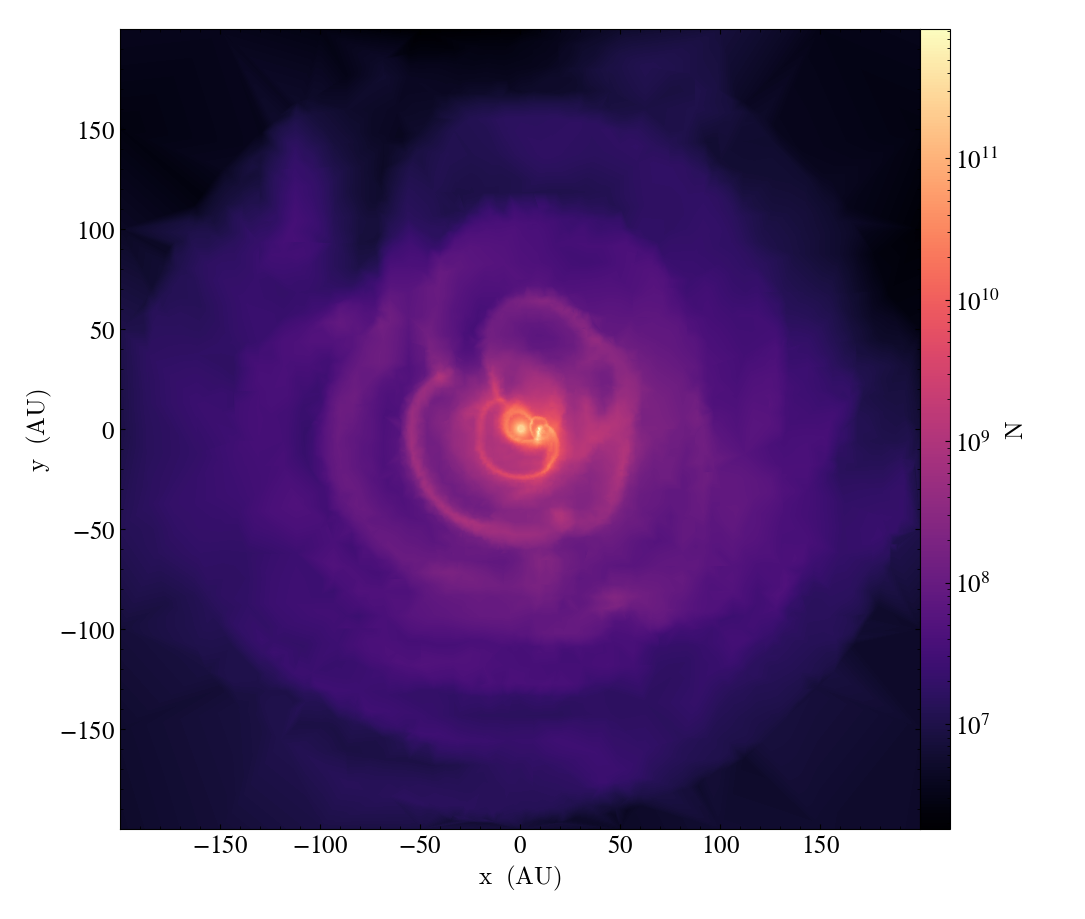

In [12]:
sl = yt.SlicePlot (ds, 'z', 'n')
sl.set_cmap       ('n', 'magma')
sl.zoom           (1.1)

Show mesh on the plot.


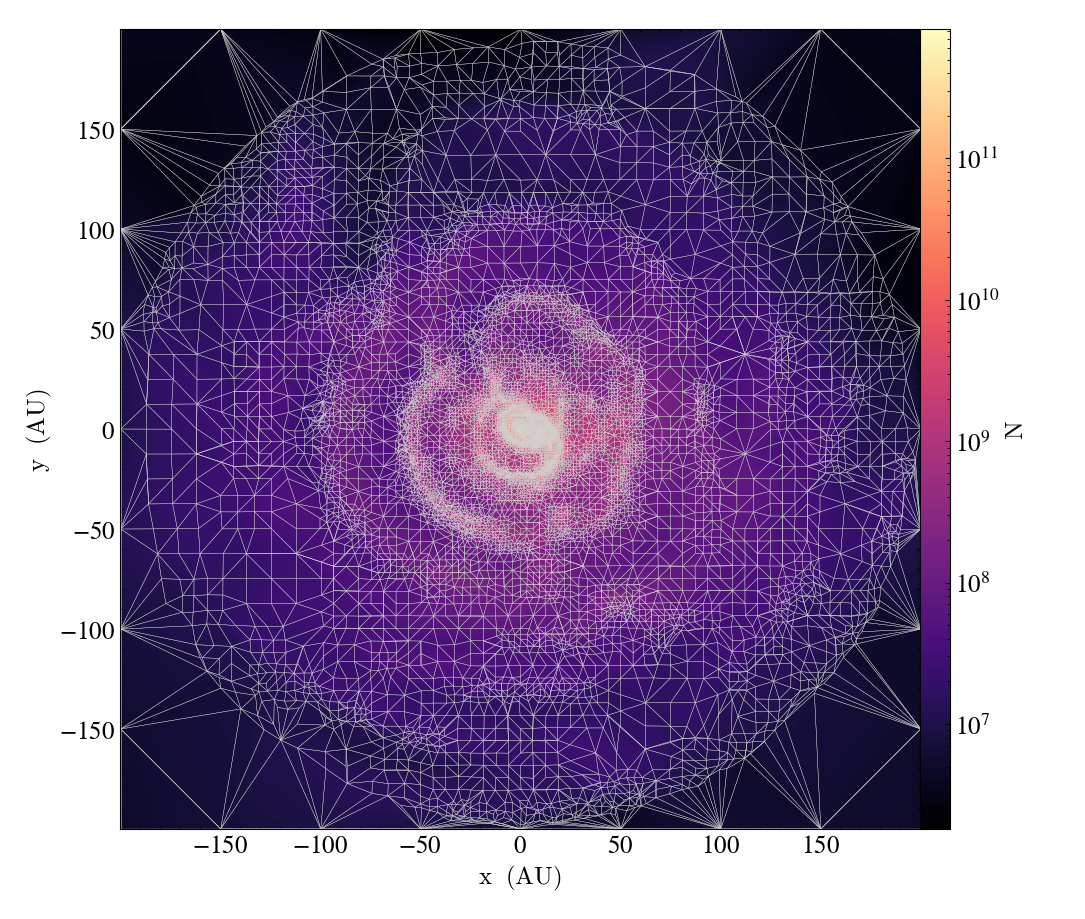

In [13]:
sl = yt.SlicePlot      (ds, 'z', 'n')
sl.set_cmap            ('n', 'magma')
sl.zoom                (1.1)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})